In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [3]:
# For all IMages
import os
from PIL import Image
from torch.utils.data import Dataset

class Foodimages(Dataset):
    def __init__(self, root_dir, transform=None, target_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []  # List to store image paths
        self.labels = []  # List to store food labels
        self.target_folders = target_folders if target_folders else []
        
        # Map target folders to labels
        self.label_map = {folder: idx for idx, folder in enumerate(self.target_folders)}

        for folder in self.target_folders:
            folder_path = os.path.join(root_dir, folder)
            if os.path.exists(folder_path):
                images_in_folder = os.listdir(folder_path)
                for image_name in images_in_folder:
                    image_path = os.path.join(folder_path, image_name)
                    self.images.append(image_path)
                    self.labels.append(self.label_map[folder])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(image_path)
        
        if self.transform:
            img = self.transform(img)

        return img, label



from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize
    # Add more transformations if needed
])

# Specify the target folders (e.g., 'chicken_wings' and 'cheese_cake')
target_folders = ['chicken_wings', 'cheesecake']

# Create dataset instance
dataset = Foodimages(root_dir='/kaggle/input/food41/images', transform=transform, target_folders=target_folders)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Now you can iterate over data_loader to get batches of images and their labels
for images, labels in data_loader:
    # Your training/validation loop here
    pass



In [4]:
labels

tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0])

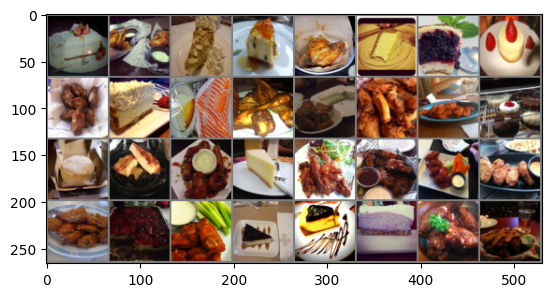

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# Function to display images in a grid
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images from the DataLoader
images, labels = next(iter(data_loader))

# Display a grid of images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, num_classes=2, img_channels=3):
        super(Discriminator, self).__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.conv_layers = nn.Sequential(
            # Input: (img_channels) x 64 x 64
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 64 x 32 x 32
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 128 x 16 x 16
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 256 x 8 x 8
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 512 x 4 x 4
        )
        
        self.fc = nn.Linear(512*4*4 + num_classes, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, labels):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten convolutional features
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.fc(x)
        out = self.sigmoid(out)
        return out.squeeze()


In [7]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, num_classes=2, img_channels=3, latent_dim=100):
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.init_size = 64 // 4  # Initial size before upsampling
        self.img_channels = img_channels
        
        self.fc = nn.Linear(latent_dim + num_classes, 1024 * self.init_size ** 2)
        
        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), -1)  # Flatten input noise
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.fc(x)
        out = out.view(out.size(0), 1024, self.init_size, self.init_size)  # Reshape to feature map shape
        out = self.conv_layers(out)
        return out


In [8]:
generator = Generator()
discriminator = Discriminator()

In [9]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))


Starting epoch 0...
[Epoch 1/300][Batch 1/63] => Generator Loss: 3.8464, Discriminator Loss: 0.1012


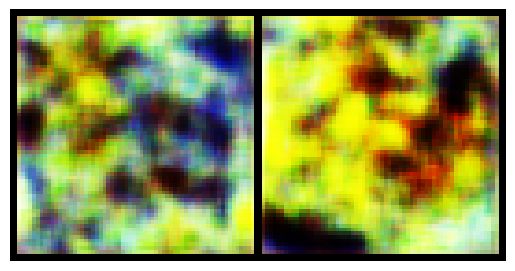

Starting epoch 1...
[Epoch 2/300][Batch 1/63] => Generator Loss: 4.9778, Discriminator Loss: 0.0371


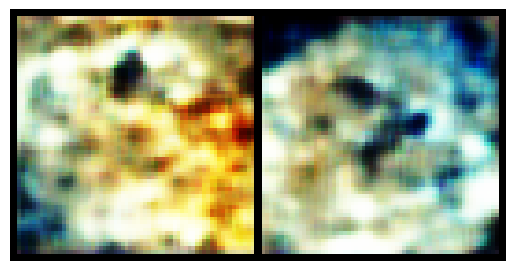

Starting epoch 2...
[Epoch 3/300][Batch 1/63] => Generator Loss: 4.7581, Discriminator Loss: 0.0794


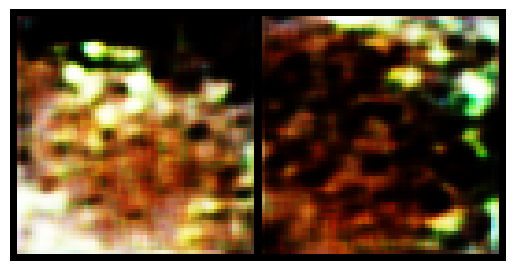

Starting epoch 3...
[Epoch 4/300][Batch 1/63] => Generator Loss: 4.9087, Discriminator Loss: 0.0787


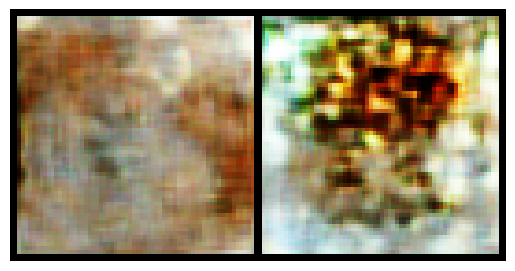

Starting epoch 4...
[Epoch 5/300][Batch 1/63] => Generator Loss: 4.6403, Discriminator Loss: 0.0983


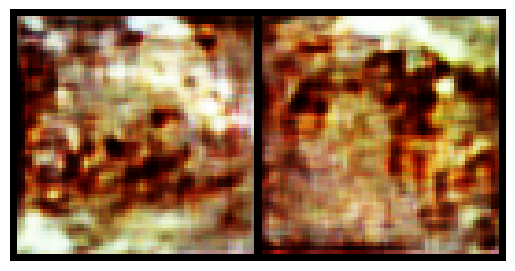

Starting epoch 5...
[Epoch 6/300][Batch 1/63] => Generator Loss: 4.8765, Discriminator Loss: 0.1830


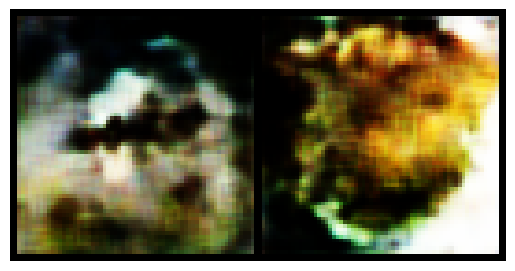

Starting epoch 6...
[Epoch 7/300][Batch 1/63] => Generator Loss: 4.2513, Discriminator Loss: 0.0766


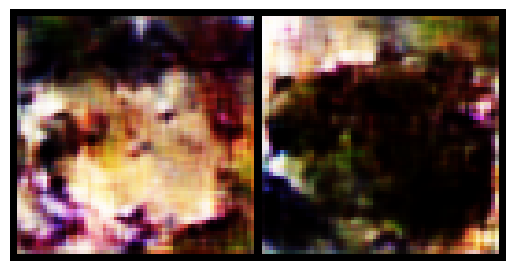

Starting epoch 7...
[Epoch 8/300][Batch 1/63] => Generator Loss: 5.7769, Discriminator Loss: 0.0451


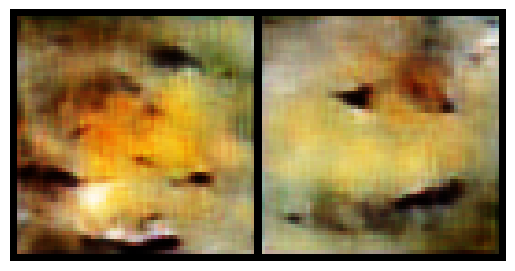

Starting epoch 8...
[Epoch 9/300][Batch 1/63] => Generator Loss: 3.5106, Discriminator Loss: 0.0681


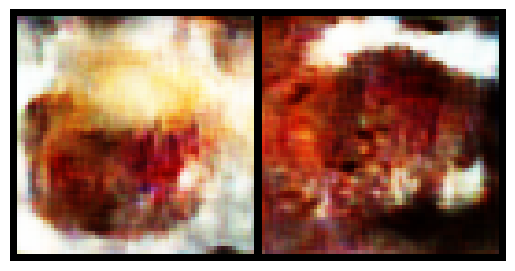

Starting epoch 9...
[Epoch 10/300][Batch 1/63] => Generator Loss: 6.0469, Discriminator Loss: 0.0866


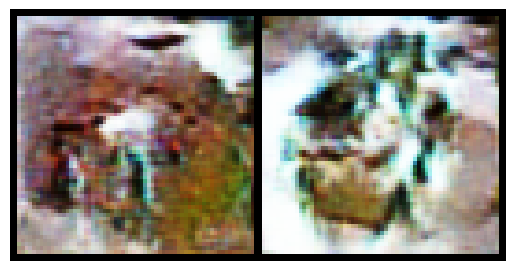

Starting epoch 10...
[Epoch 11/300][Batch 1/63] => Generator Loss: 7.9767, Discriminator Loss: 0.0206


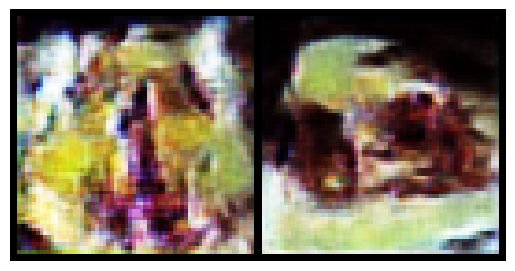

Starting epoch 11...
[Epoch 12/300][Batch 1/63] => Generator Loss: 8.9267, Discriminator Loss: 0.0066


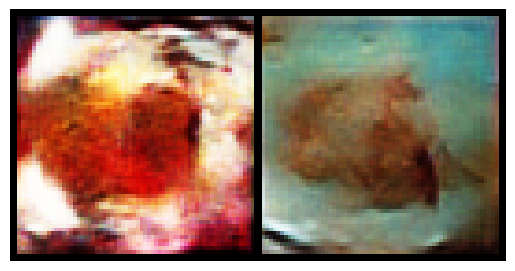

Starting epoch 12...
[Epoch 13/300][Batch 1/63] => Generator Loss: 7.2253, Discriminator Loss: 0.0128


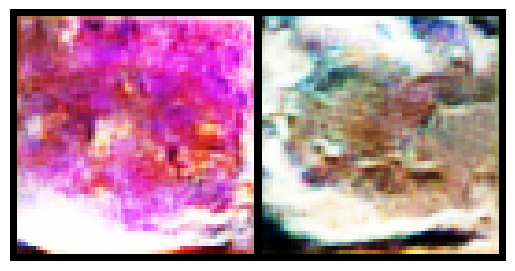

Starting epoch 13...
[Epoch 14/300][Batch 1/63] => Generator Loss: 7.6653, Discriminator Loss: 0.0188


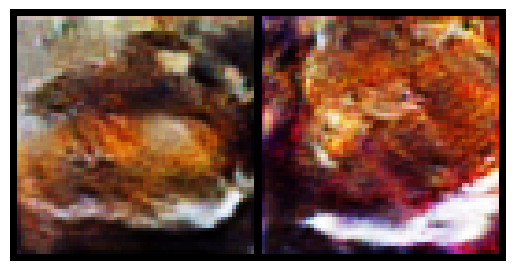

Starting epoch 14...
[Epoch 15/300][Batch 1/63] => Generator Loss: 4.8050, Discriminator Loss: 0.0292


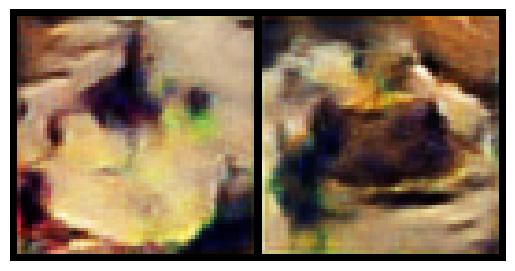

Starting epoch 15...
[Epoch 16/300][Batch 1/63] => Generator Loss: 6.2427, Discriminator Loss: 0.0236


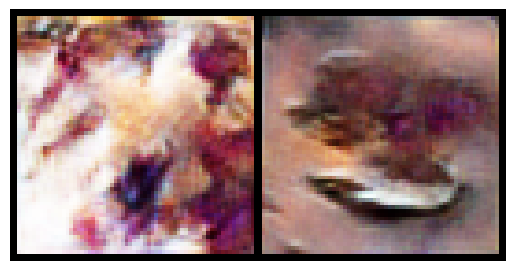

Starting epoch 16...
[Epoch 17/300][Batch 1/63] => Generator Loss: 7.5261, Discriminator Loss: 0.0073


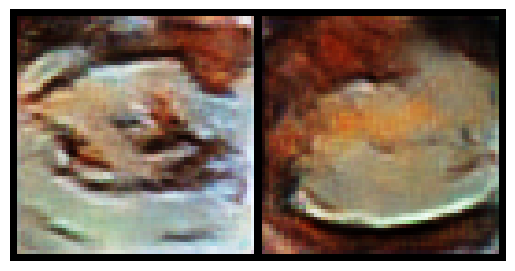

Starting epoch 17...
[Epoch 18/300][Batch 1/63] => Generator Loss: 8.0381, Discriminator Loss: 0.4334


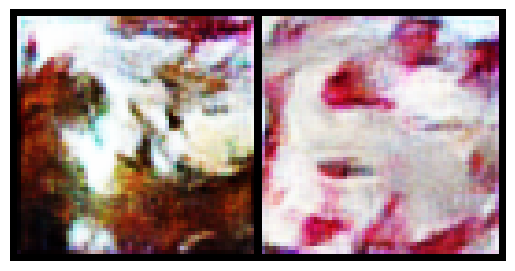

Starting epoch 18...
[Epoch 19/300][Batch 1/63] => Generator Loss: 8.5620, Discriminator Loss: 0.0212


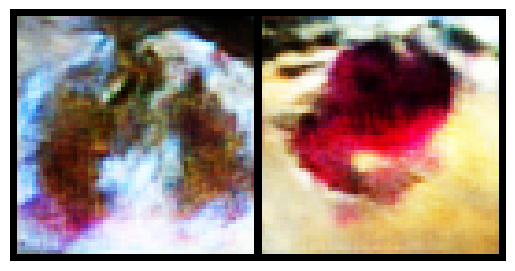

Starting epoch 19...
[Epoch 20/300][Batch 1/63] => Generator Loss: 5.7363, Discriminator Loss: 0.0353


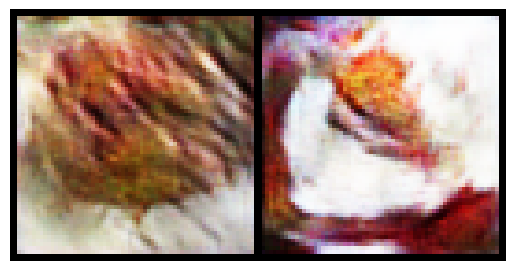

Starting epoch 20...
[Epoch 21/300][Batch 1/63] => Generator Loss: 8.0181, Discriminator Loss: 0.0454


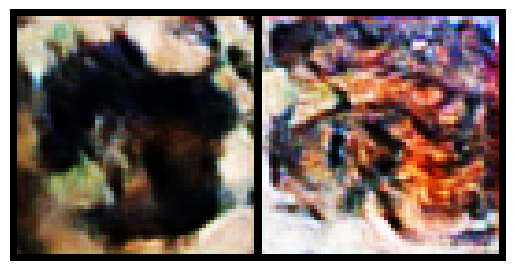

Starting epoch 21...
[Epoch 22/300][Batch 1/63] => Generator Loss: 7.6309, Discriminator Loss: 0.0120


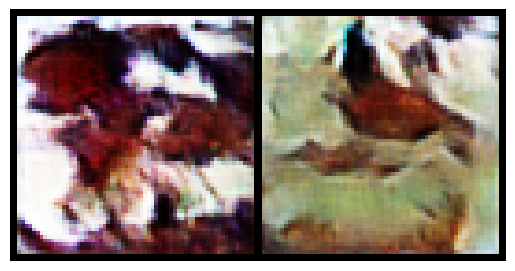

Starting epoch 22...
[Epoch 23/300][Batch 1/63] => Generator Loss: 7.2402, Discriminator Loss: 0.0192


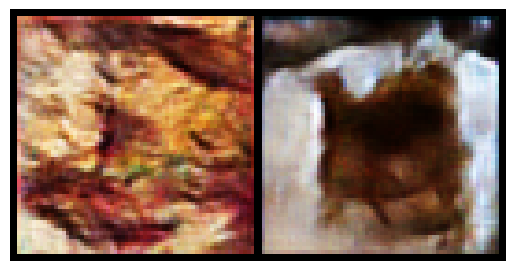

Starting epoch 23...
[Epoch 24/300][Batch 1/63] => Generator Loss: 9.3805, Discriminator Loss: 0.0615


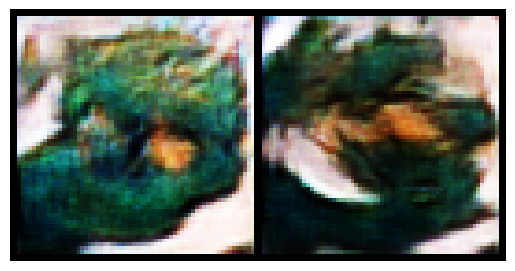

Starting epoch 24...
[Epoch 25/300][Batch 1/63] => Generator Loss: 7.7879, Discriminator Loss: 0.0034


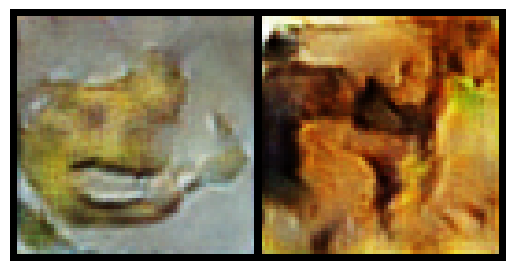

Starting epoch 25...
[Epoch 26/300][Batch 1/63] => Generator Loss: 6.9359, Discriminator Loss: 0.0351


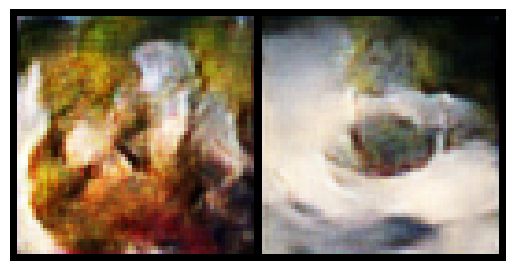

Starting epoch 26...
[Epoch 27/300][Batch 1/63] => Generator Loss: 7.3170, Discriminator Loss: 0.0142


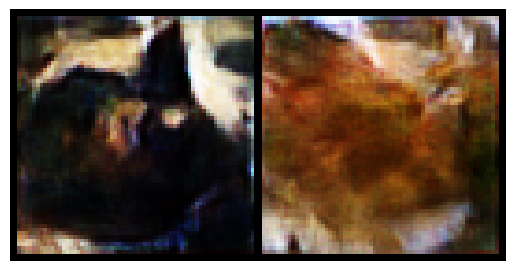

Starting epoch 27...
[Epoch 28/300][Batch 1/63] => Generator Loss: 7.3007, Discriminator Loss: 0.0038


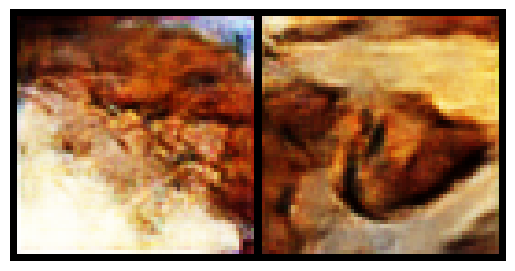

Starting epoch 28...
[Epoch 29/300][Batch 1/63] => Generator Loss: 9.7056, Discriminator Loss: 0.0242


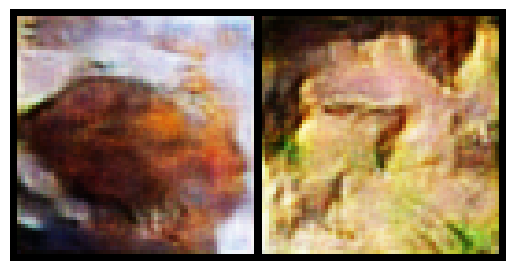

Starting epoch 29...
[Epoch 30/300][Batch 1/63] => Generator Loss: 10.2804, Discriminator Loss: 0.0010


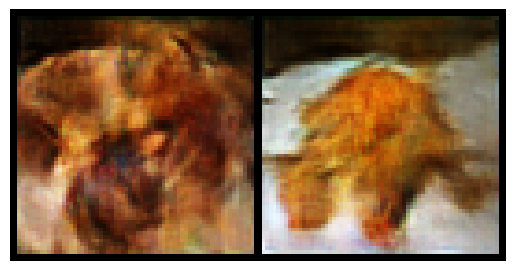

Starting epoch 30...
[Epoch 31/300][Batch 1/63] => Generator Loss: 8.2024, Discriminator Loss: 0.0566


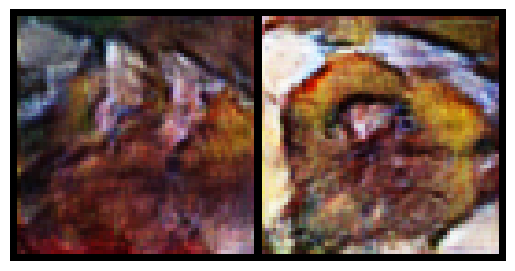

Starting epoch 31...
[Epoch 32/300][Batch 1/63] => Generator Loss: 9.3068, Discriminator Loss: 0.0476


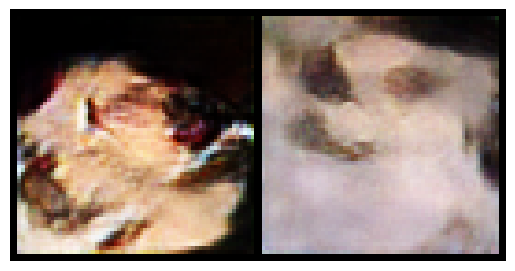

Starting epoch 32...
[Epoch 33/300][Batch 1/63] => Generator Loss: 9.2907, Discriminator Loss: 0.1102


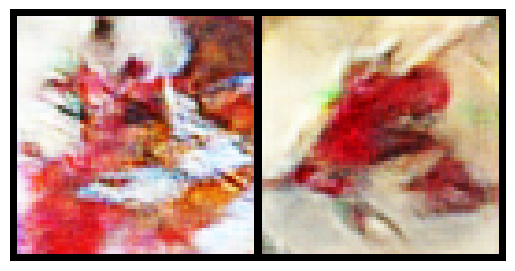

Starting epoch 33...
[Epoch 34/300][Batch 1/63] => Generator Loss: 6.1059, Discriminator Loss: 0.0111


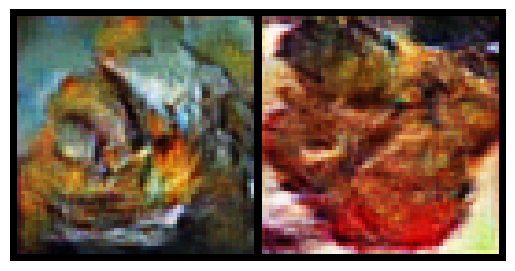

Starting epoch 34...
[Epoch 35/300][Batch 1/63] => Generator Loss: 8.8343, Discriminator Loss: 0.0018


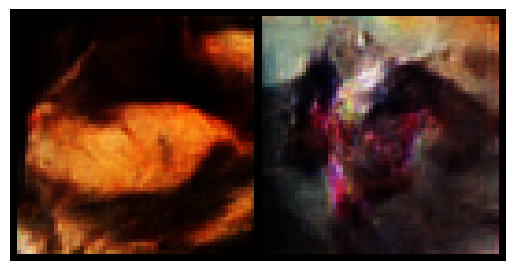

Starting epoch 35...
[Epoch 36/300][Batch 1/63] => Generator Loss: 9.6303, Discriminator Loss: 0.0019


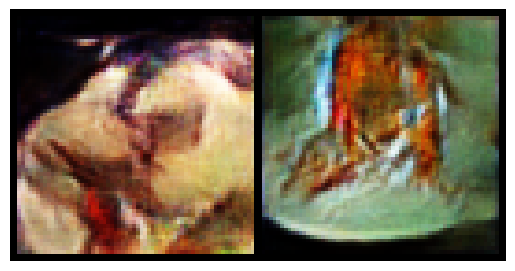

Starting epoch 36...
[Epoch 37/300][Batch 1/63] => Generator Loss: 9.3303, Discriminator Loss: 0.0017


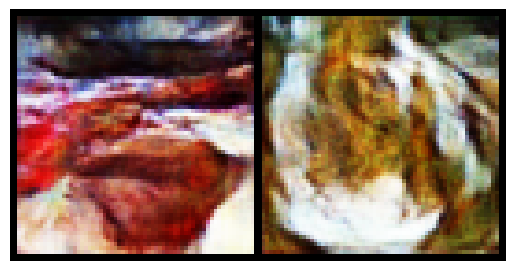

Starting epoch 37...
[Epoch 38/300][Batch 1/63] => Generator Loss: 6.9201, Discriminator Loss: 0.0117


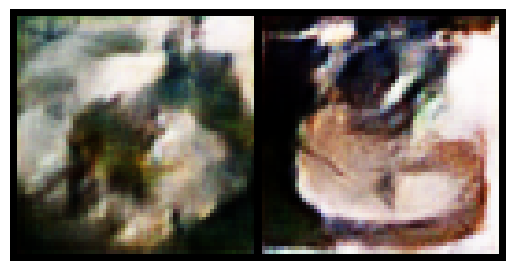

Starting epoch 38...
[Epoch 39/300][Batch 1/63] => Generator Loss: 8.9962, Discriminator Loss: 0.0348


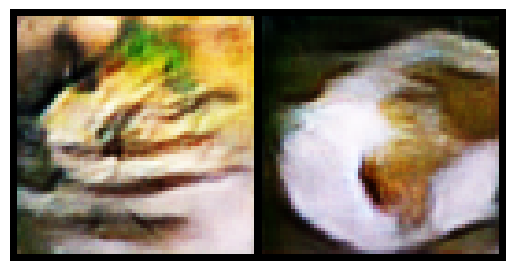

Starting epoch 39...
[Epoch 40/300][Batch 1/63] => Generator Loss: 8.7929, Discriminator Loss: 0.0064


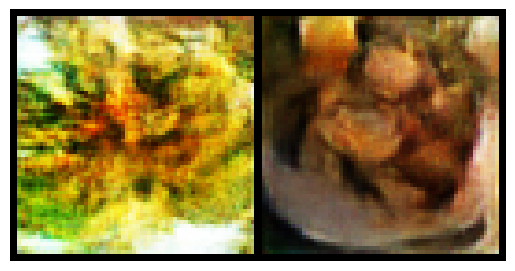

Starting epoch 40...
[Epoch 41/300][Batch 1/63] => Generator Loss: 8.4254, Discriminator Loss: 0.0214


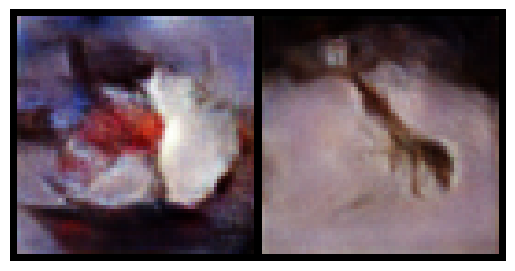

Starting epoch 41...
[Epoch 42/300][Batch 1/63] => Generator Loss: 4.4992, Discriminator Loss: 0.0214


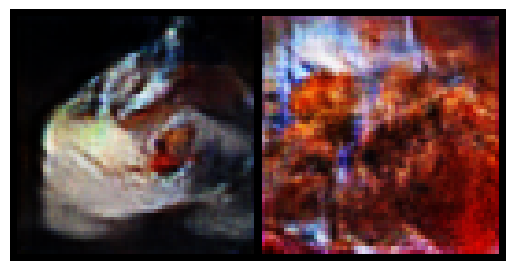

Starting epoch 42...
[Epoch 43/300][Batch 1/63] => Generator Loss: 5.6394, Discriminator Loss: 0.1250


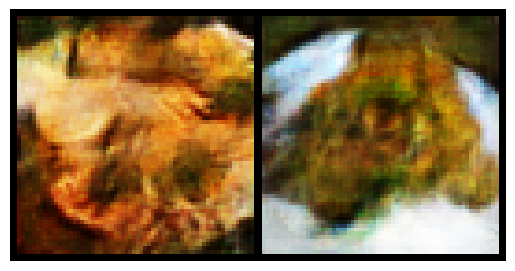

Starting epoch 43...
[Epoch 44/300][Batch 1/63] => Generator Loss: 6.4310, Discriminator Loss: 0.0073


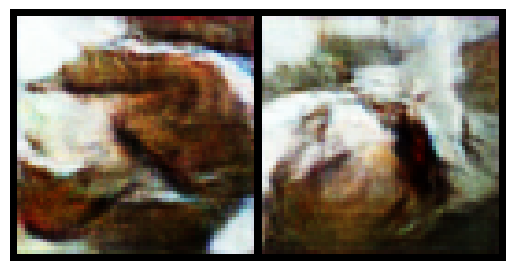

Starting epoch 44...
[Epoch 45/300][Batch 1/63] => Generator Loss: 6.5902, Discriminator Loss: 0.0551


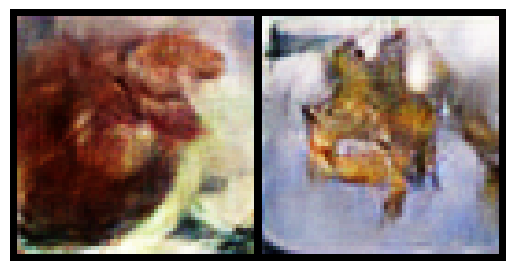

Starting epoch 45...
[Epoch 46/300][Batch 1/63] => Generator Loss: 8.0473, Discriminator Loss: 0.0246


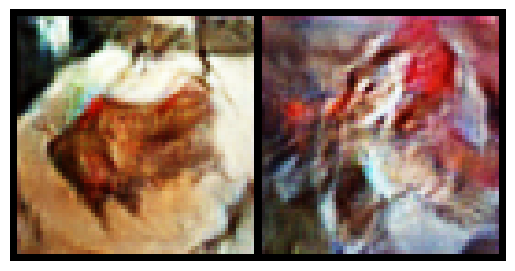

Starting epoch 46...
[Epoch 47/300][Batch 1/63] => Generator Loss: 7.0962, Discriminator Loss: 0.0077


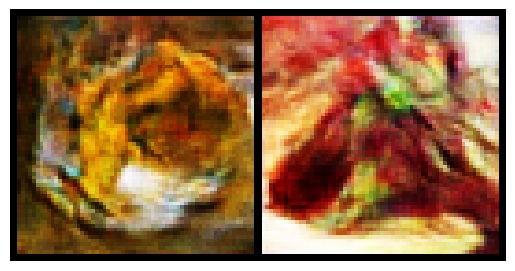

Starting epoch 47...
[Epoch 48/300][Batch 1/63] => Generator Loss: 9.3594, Discriminator Loss: 0.0047


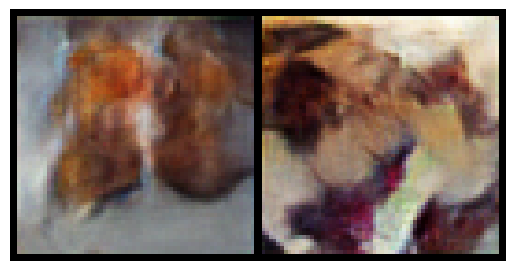

Starting epoch 48...
[Epoch 49/300][Batch 1/63] => Generator Loss: 5.4598, Discriminator Loss: 0.0108


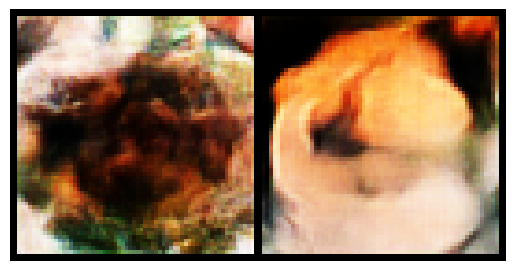

Starting epoch 49...
[Epoch 50/300][Batch 1/63] => Generator Loss: 6.4856, Discriminator Loss: 0.0077


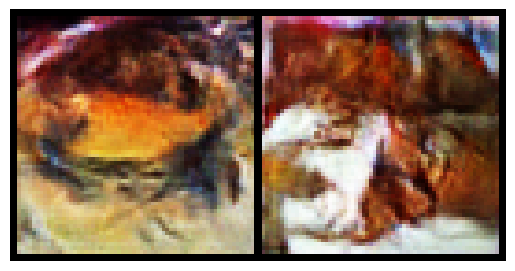

Starting epoch 50...
[Epoch 51/300][Batch 1/63] => Generator Loss: 8.5564, Discriminator Loss: 0.0023


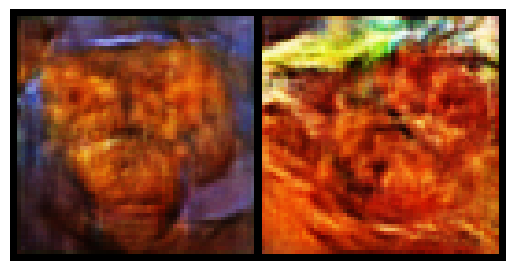

Starting epoch 51...
[Epoch 52/300][Batch 1/63] => Generator Loss: 8.6104, Discriminator Loss: 0.0100


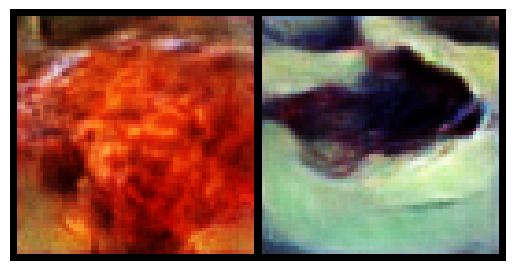

Starting epoch 52...
[Epoch 53/300][Batch 1/63] => Generator Loss: 8.8192, Discriminator Loss: 0.0032


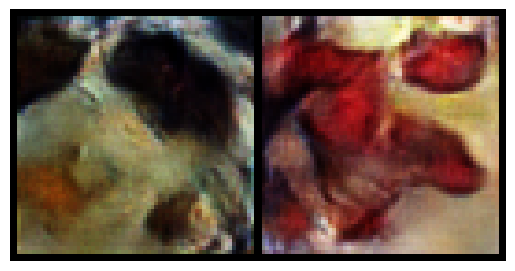

Starting epoch 53...
[Epoch 54/300][Batch 1/63] => Generator Loss: 7.9275, Discriminator Loss: 0.0286


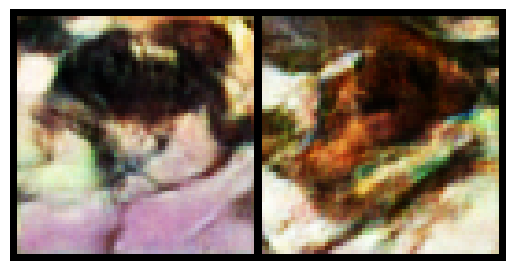

Starting epoch 54...
[Epoch 55/300][Batch 1/63] => Generator Loss: 7.8256, Discriminator Loss: 0.0033


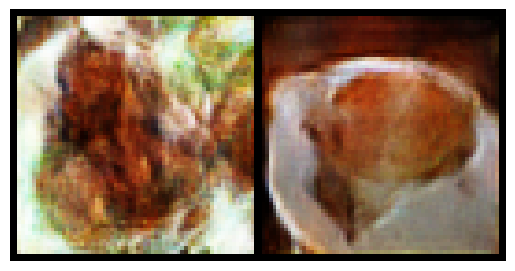

Starting epoch 55...
[Epoch 56/300][Batch 1/63] => Generator Loss: 10.6082, Discriminator Loss: 0.0130


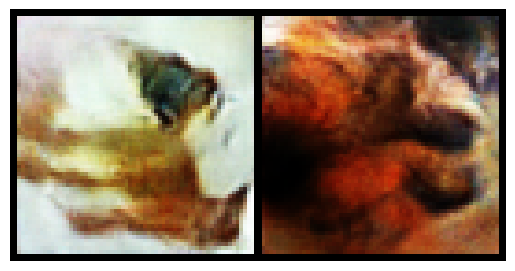

Starting epoch 56...
[Epoch 57/300][Batch 1/63] => Generator Loss: 5.8123, Discriminator Loss: 0.0074


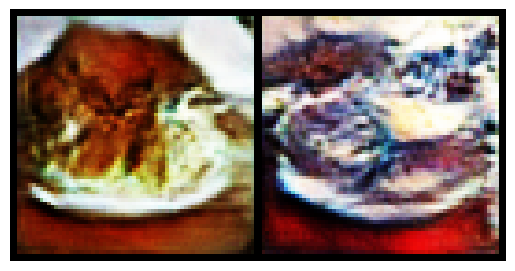

Starting epoch 57...
[Epoch 58/300][Batch 1/63] => Generator Loss: 10.5048, Discriminator Loss: 0.0041


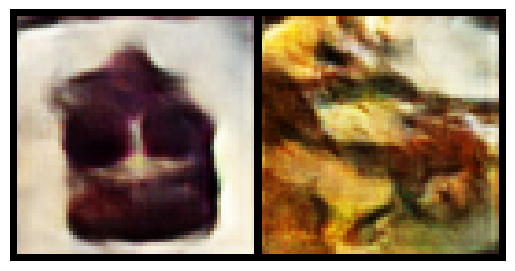

Starting epoch 58...
[Epoch 59/300][Batch 1/63] => Generator Loss: 10.0876, Discriminator Loss: 0.0109


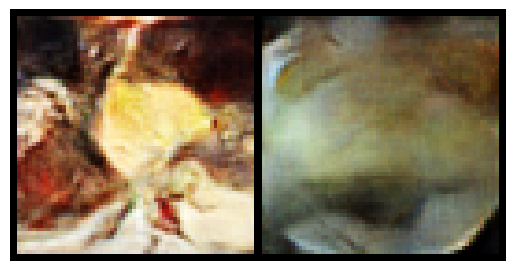

Starting epoch 59...
[Epoch 60/300][Batch 1/63] => Generator Loss: 5.6215, Discriminator Loss: 0.0114


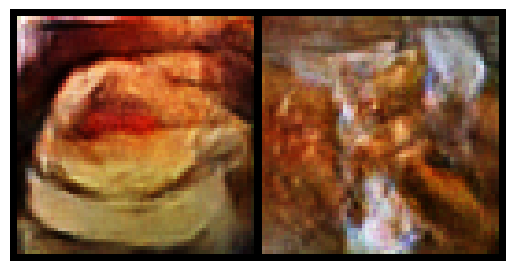

Starting epoch 60...
[Epoch 61/300][Batch 1/63] => Generator Loss: 8.1373, Discriminator Loss: 0.0098


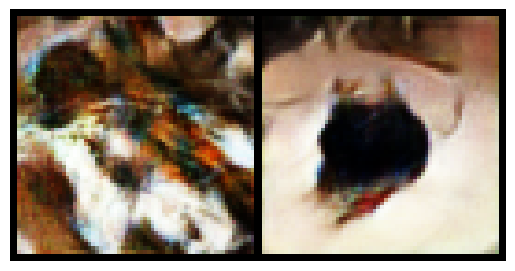

Starting epoch 61...
[Epoch 62/300][Batch 1/63] => Generator Loss: 7.7013, Discriminator Loss: 0.0014


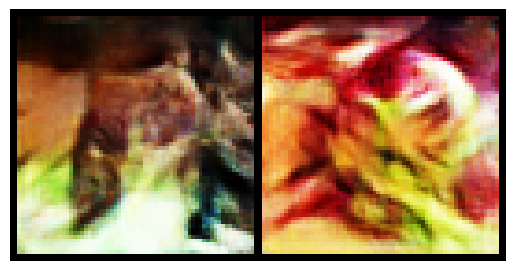

Starting epoch 62...
[Epoch 63/300][Batch 1/63] => Generator Loss: 7.6690, Discriminator Loss: 0.0402


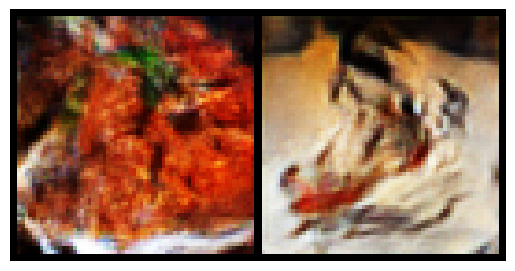

Starting epoch 63...
[Epoch 64/300][Batch 1/63] => Generator Loss: 7.3623, Discriminator Loss: 0.0454


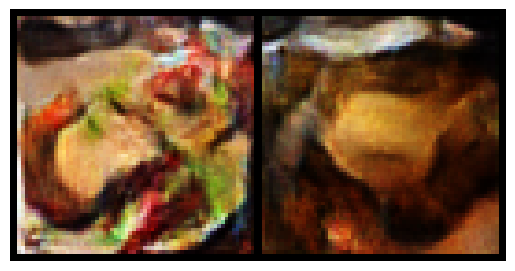

Starting epoch 64...
[Epoch 65/300][Batch 1/63] => Generator Loss: 7.0048, Discriminator Loss: 0.0119


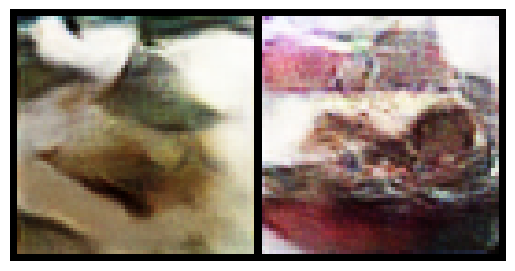

Starting epoch 65...
[Epoch 66/300][Batch 1/63] => Generator Loss: 9.2868, Discriminator Loss: 0.0154


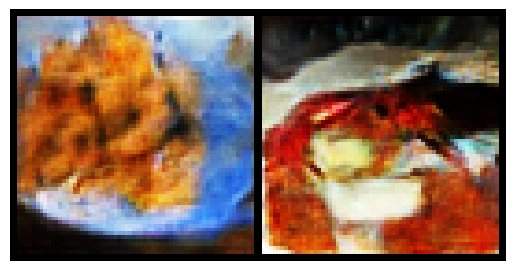

Starting epoch 66...
[Epoch 67/300][Batch 1/63] => Generator Loss: 6.7933, Discriminator Loss: 0.0093


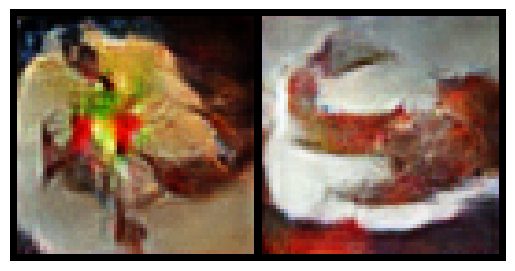

Starting epoch 67...
[Epoch 68/300][Batch 1/63] => Generator Loss: 7.2953, Discriminator Loss: 0.0056


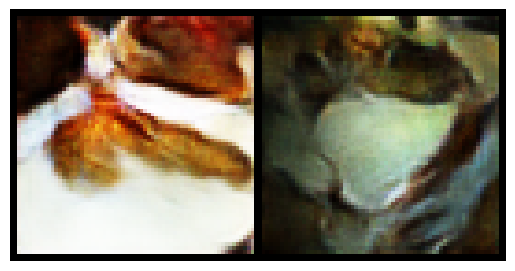

Starting epoch 68...
[Epoch 69/300][Batch 1/63] => Generator Loss: 7.9086, Discriminator Loss: 0.0033


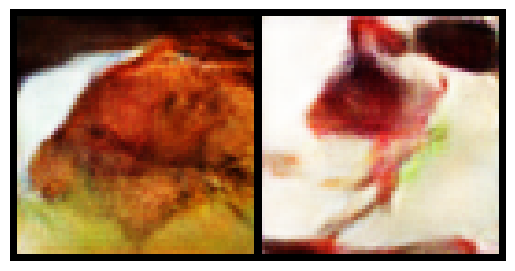

Starting epoch 69...
[Epoch 70/300][Batch 1/63] => Generator Loss: 15.8970, Discriminator Loss: 0.0078


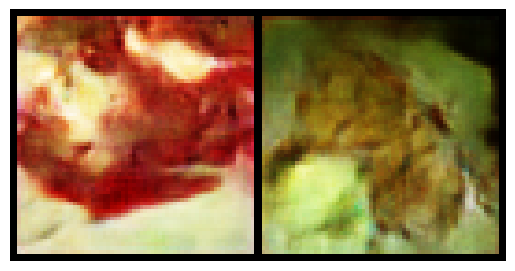

Starting epoch 70...
[Epoch 71/300][Batch 1/63] => Generator Loss: 13.2275, Discriminator Loss: 0.0020


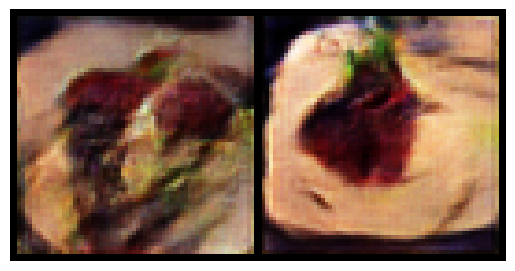

Starting epoch 71...
[Epoch 72/300][Batch 1/63] => Generator Loss: 5.6164, Discriminator Loss: 0.0161


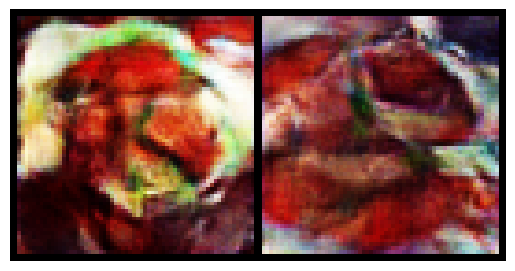

Starting epoch 72...
[Epoch 73/300][Batch 1/63] => Generator Loss: 7.4203, Discriminator Loss: 0.0034


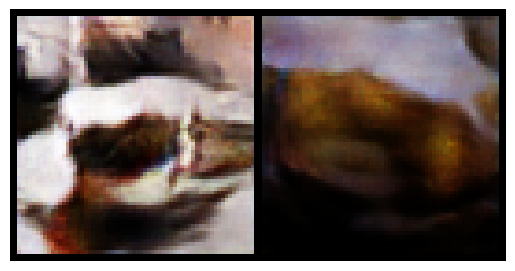

Starting epoch 73...
[Epoch 74/300][Batch 1/63] => Generator Loss: 9.3762, Discriminator Loss: 0.0029


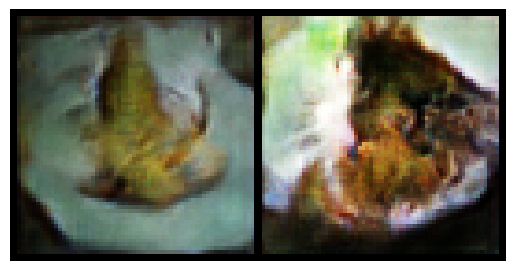

Starting epoch 74...
[Epoch 75/300][Batch 1/63] => Generator Loss: 8.8276, Discriminator Loss: 0.0679


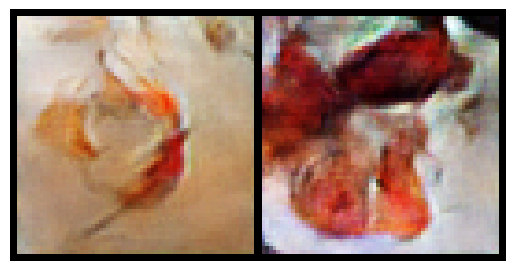

Starting epoch 75...
[Epoch 76/300][Batch 1/63] => Generator Loss: 7.3393, Discriminator Loss: 0.0069


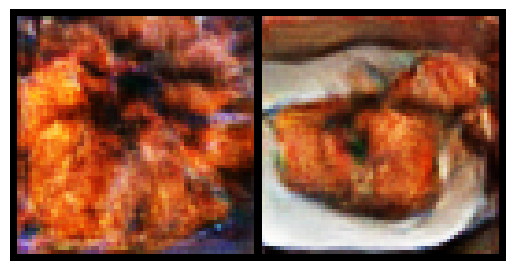

Starting epoch 76...
[Epoch 77/300][Batch 1/63] => Generator Loss: 5.3553, Discriminator Loss: 0.0121


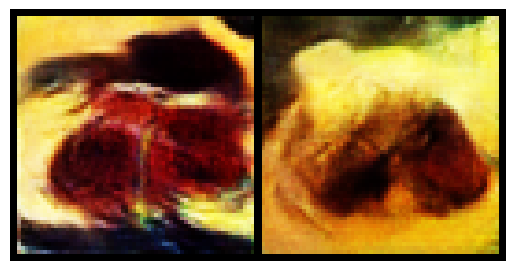

Starting epoch 77...
[Epoch 78/300][Batch 1/63] => Generator Loss: 7.8002, Discriminator Loss: 0.0019


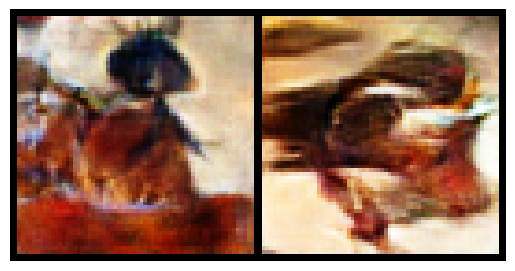

Starting epoch 78...
[Epoch 79/300][Batch 1/63] => Generator Loss: 8.2654, Discriminator Loss: 0.0297


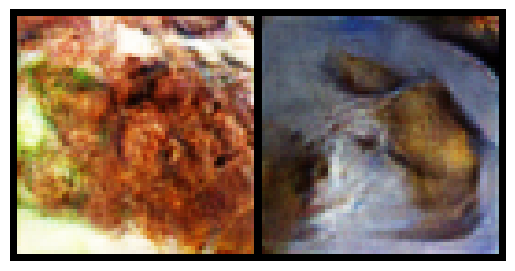

Starting epoch 79...
[Epoch 80/300][Batch 1/63] => Generator Loss: 6.0762, Discriminator Loss: 0.0125


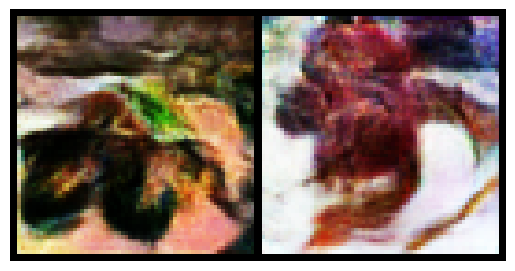

Starting epoch 80...
[Epoch 81/300][Batch 1/63] => Generator Loss: 10.7689, Discriminator Loss: 0.0012


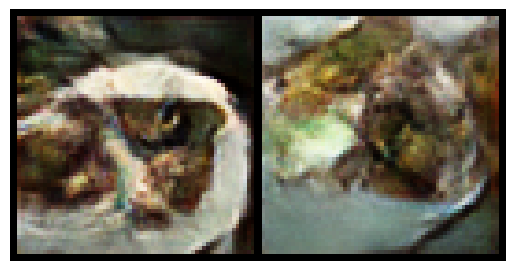

Starting epoch 81...
[Epoch 82/300][Batch 1/63] => Generator Loss: 10.0659, Discriminator Loss: 0.0018


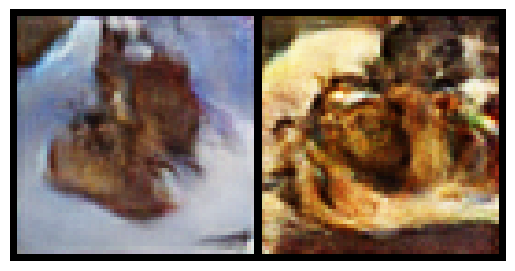

Starting epoch 82...
[Epoch 83/300][Batch 1/63] => Generator Loss: 6.7678, Discriminator Loss: 0.0055


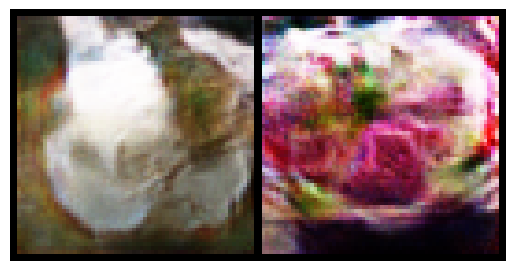

Starting epoch 83...
[Epoch 84/300][Batch 1/63] => Generator Loss: 7.5952, Discriminator Loss: 0.0021


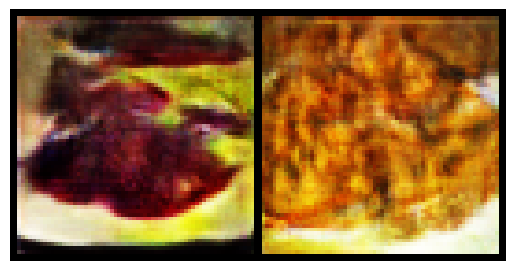

Starting epoch 84...
[Epoch 85/300][Batch 1/63] => Generator Loss: 5.2569, Discriminator Loss: 0.0244


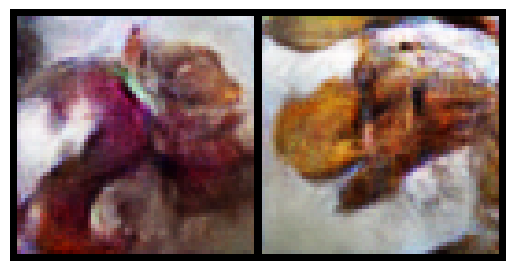

Starting epoch 85...
[Epoch 86/300][Batch 1/63] => Generator Loss: 6.3503, Discriminator Loss: 0.0132


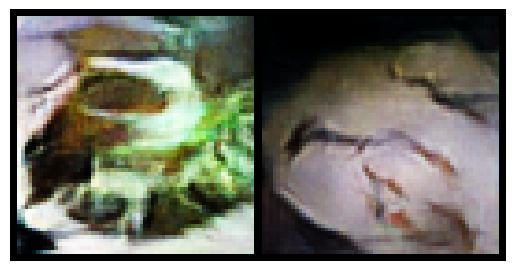

Starting epoch 86...
[Epoch 87/300][Batch 1/63] => Generator Loss: 7.3042, Discriminator Loss: 0.0088


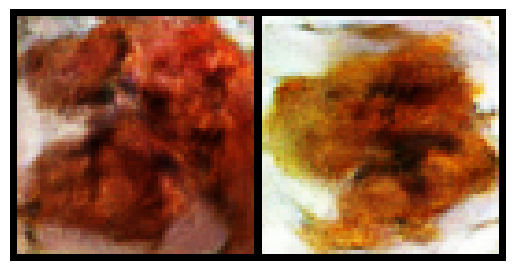

Starting epoch 87...
[Epoch 88/300][Batch 1/63] => Generator Loss: 6.4826, Discriminator Loss: 0.0025


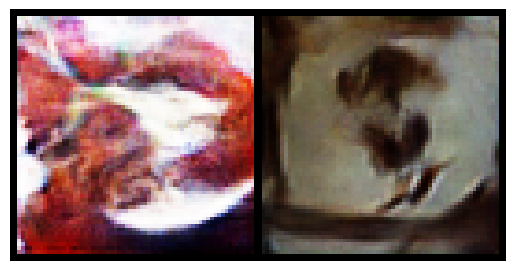

Starting epoch 88...
[Epoch 89/300][Batch 1/63] => Generator Loss: 6.8025, Discriminator Loss: 0.0044


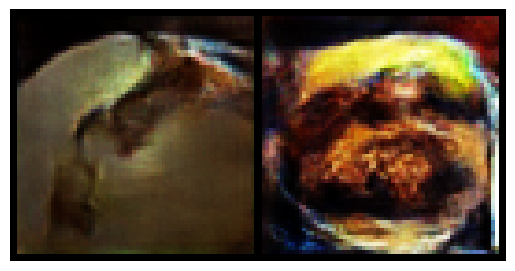

Starting epoch 89...
[Epoch 90/300][Batch 1/63] => Generator Loss: 8.4963, Discriminator Loss: 0.0054


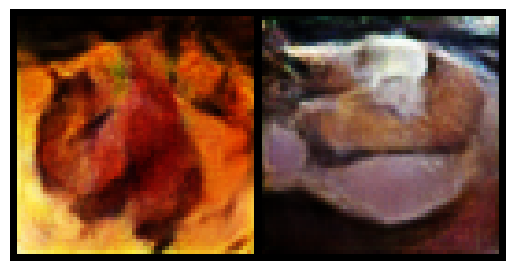

Starting epoch 90...
[Epoch 91/300][Batch 1/63] => Generator Loss: 8.1852, Discriminator Loss: 0.0082


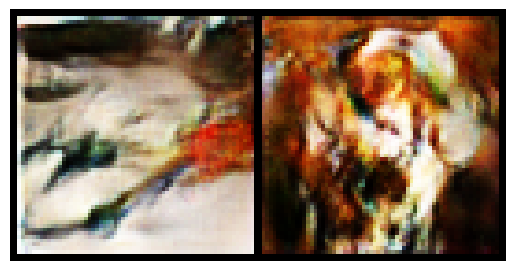

Starting epoch 91...
[Epoch 92/300][Batch 1/63] => Generator Loss: 8.3656, Discriminator Loss: 0.0712


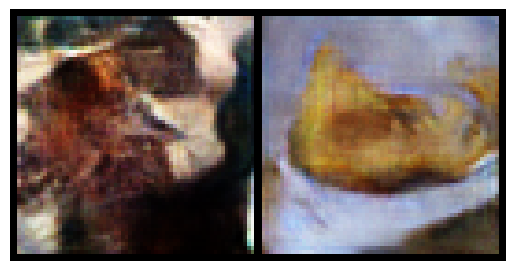

Starting epoch 92...
[Epoch 93/300][Batch 1/63] => Generator Loss: 6.3332, Discriminator Loss: 0.0106


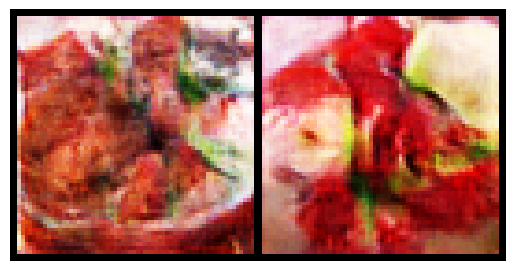

Starting epoch 93...
[Epoch 94/300][Batch 1/63] => Generator Loss: 7.3983, Discriminator Loss: 0.0162


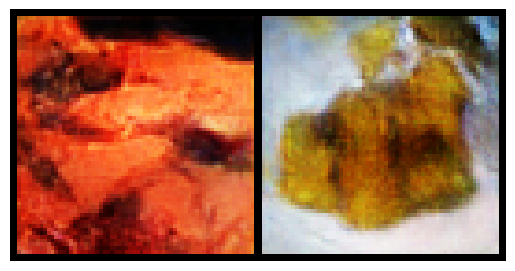

Starting epoch 94...
[Epoch 95/300][Batch 1/63] => Generator Loss: 5.6529, Discriminator Loss: 0.0113


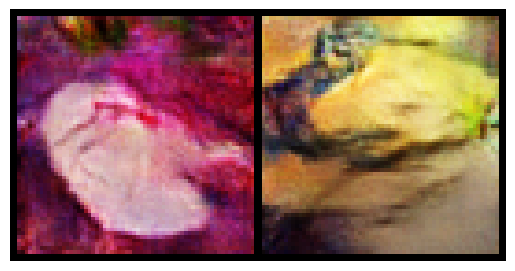

Starting epoch 95...
[Epoch 96/300][Batch 1/63] => Generator Loss: 6.9129, Discriminator Loss: 0.0091


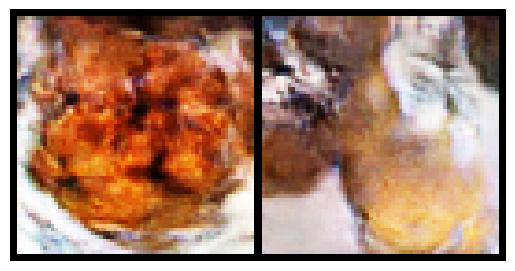

Starting epoch 96...
[Epoch 97/300][Batch 1/63] => Generator Loss: 7.5500, Discriminator Loss: 0.0045


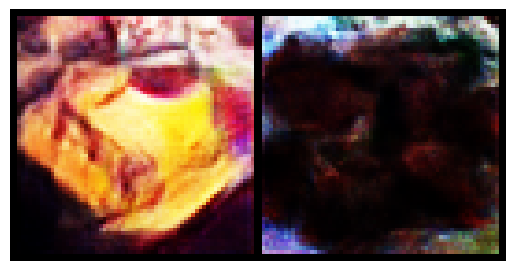

Starting epoch 97...
[Epoch 98/300][Batch 1/63] => Generator Loss: 7.7718, Discriminator Loss: 0.0017


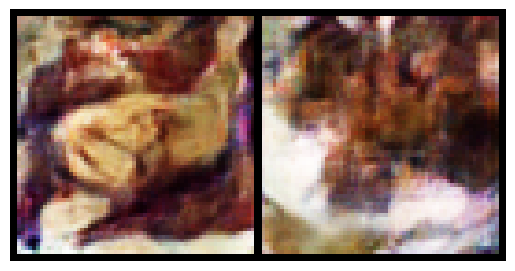

Starting epoch 98...
[Epoch 99/300][Batch 1/63] => Generator Loss: 8.7778, Discriminator Loss: 0.0047


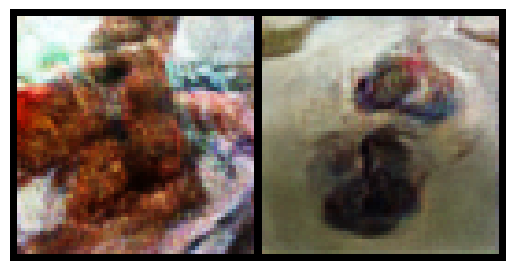

Starting epoch 99...
[Epoch 100/300][Batch 1/63] => Generator Loss: 7.0749, Discriminator Loss: 0.0082


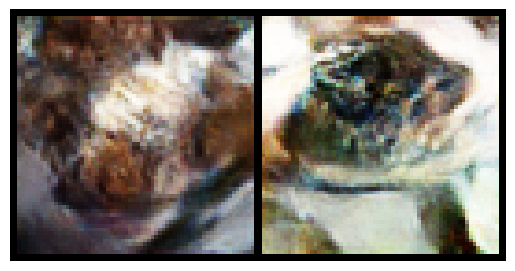

Starting epoch 100...
[Epoch 101/300][Batch 1/63] => Generator Loss: 7.4719, Discriminator Loss: 0.0065


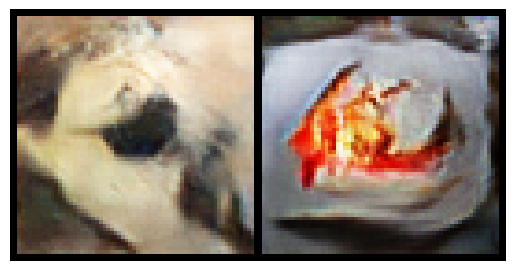

Starting epoch 101...
[Epoch 102/300][Batch 1/63] => Generator Loss: 8.0998, Discriminator Loss: 0.0056


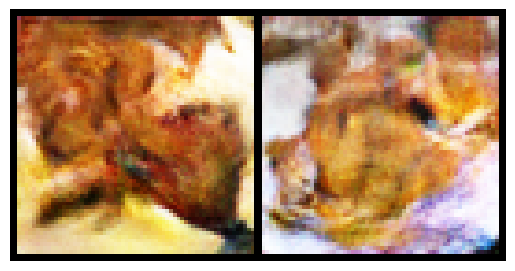

Starting epoch 102...
[Epoch 103/300][Batch 1/63] => Generator Loss: 9.1701, Discriminator Loss: 0.0030


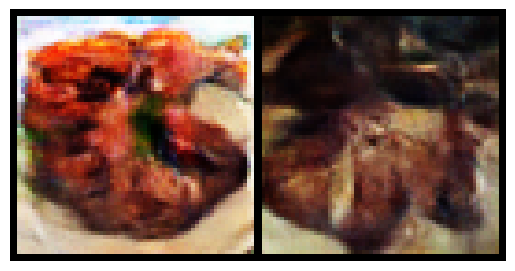

Starting epoch 103...
[Epoch 104/300][Batch 1/63] => Generator Loss: 7.7124, Discriminator Loss: 0.0030


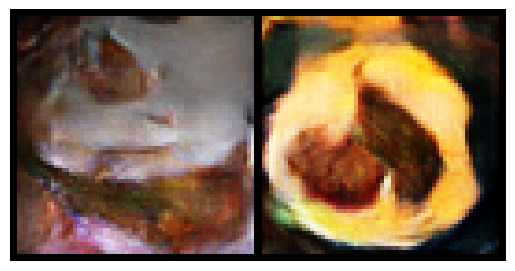

Starting epoch 104...
[Epoch 105/300][Batch 1/63] => Generator Loss: 6.4032, Discriminator Loss: 0.3263


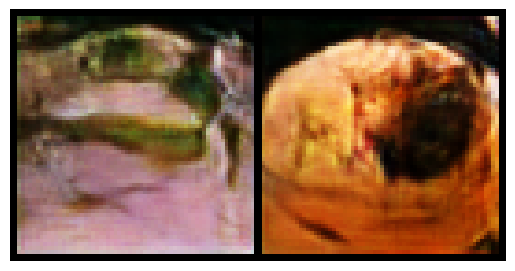

Starting epoch 105...
[Epoch 106/300][Batch 1/63] => Generator Loss: 9.4317, Discriminator Loss: 0.0020


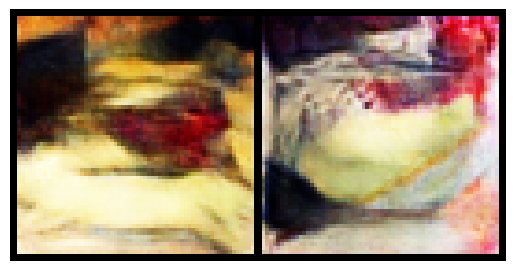

Starting epoch 106...
[Epoch 107/300][Batch 1/63] => Generator Loss: 7.6964, Discriminator Loss: 0.0037


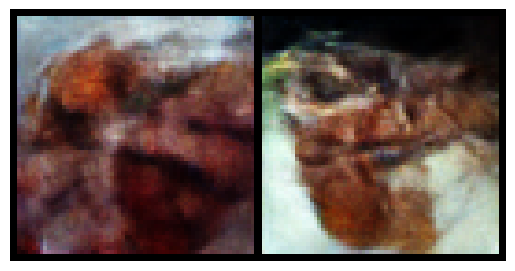

Starting epoch 107...
[Epoch 108/300][Batch 1/63] => Generator Loss: 9.2428, Discriminator Loss: 0.0106


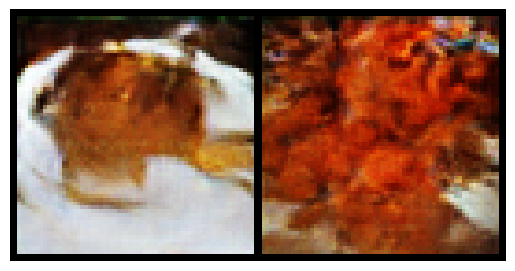

Starting epoch 108...
[Epoch 109/300][Batch 1/63] => Generator Loss: 7.8364, Discriminator Loss: 0.0041


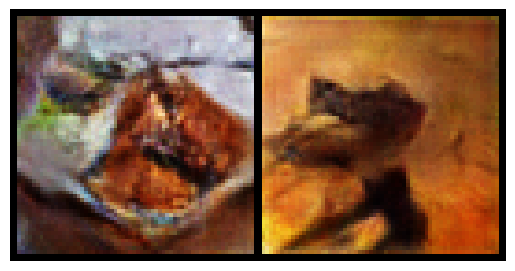

Starting epoch 109...
[Epoch 110/300][Batch 1/63] => Generator Loss: 10.3705, Discriminator Loss: 0.0011


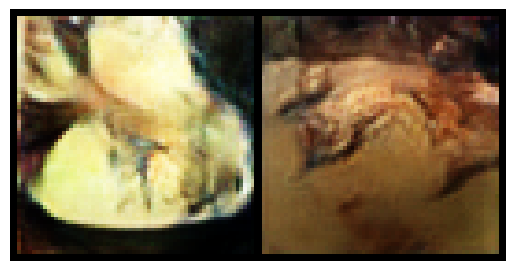

Starting epoch 110...
[Epoch 111/300][Batch 1/63] => Generator Loss: 7.1776, Discriminator Loss: 0.0092


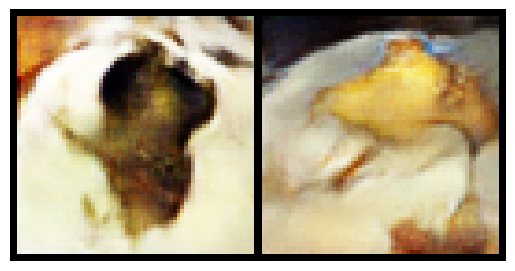

Starting epoch 111...
[Epoch 112/300][Batch 1/63] => Generator Loss: 8.8171, Discriminator Loss: 0.0021


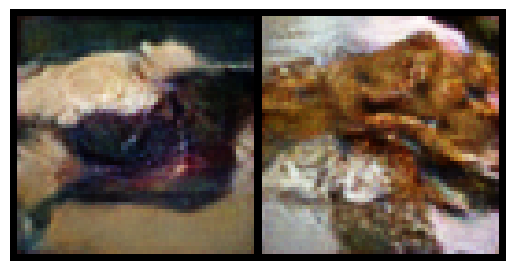

Starting epoch 112...
[Epoch 113/300][Batch 1/63] => Generator Loss: 7.6583, Discriminator Loss: 0.0018


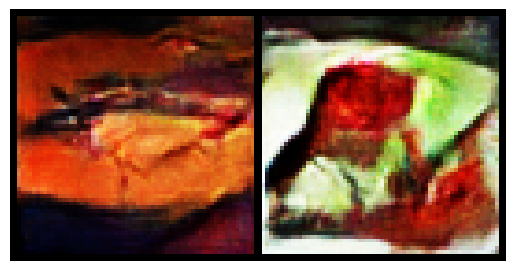

Starting epoch 113...
[Epoch 114/300][Batch 1/63] => Generator Loss: 6.3002, Discriminator Loss: 0.0025


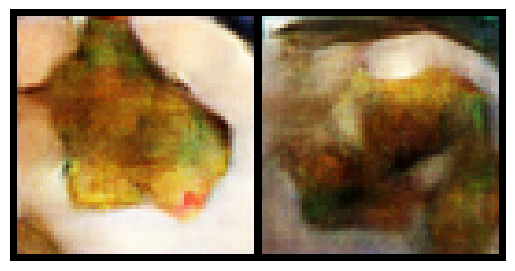

Starting epoch 114...
[Epoch 115/300][Batch 1/63] => Generator Loss: 9.6191, Discriminator Loss: 0.1013


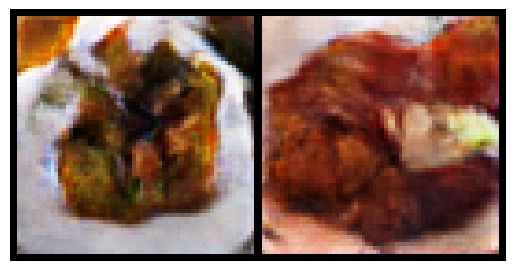

Starting epoch 115...
[Epoch 116/300][Batch 1/63] => Generator Loss: 8.3747, Discriminator Loss: 0.0145


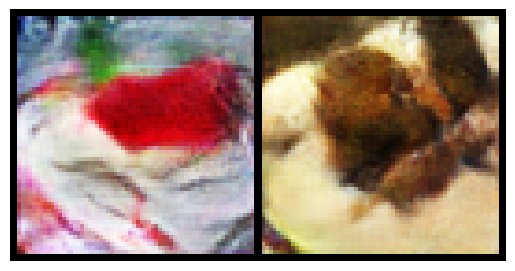

Starting epoch 116...
[Epoch 117/300][Batch 1/63] => Generator Loss: 6.2937, Discriminator Loss: 0.0114


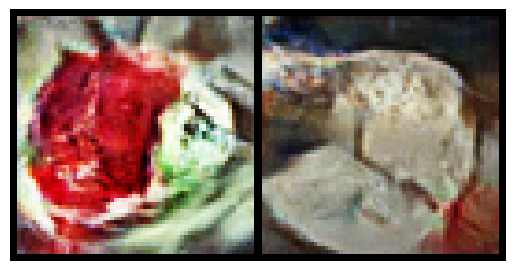

Starting epoch 117...
[Epoch 118/300][Batch 1/63] => Generator Loss: 6.1913, Discriminator Loss: 0.0129


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Assuming your generator is defined as Generator(num_classes=num_classes, img_channels=img_channels)
# and discriminator is defined as Discriminator(num_classes=num_classes, img_channels=img_channels)
# You can replace num_classes and img_channels with the appropriate values from your dataset.


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, num_classes=2):
    g_optimizer.zero_grad()
    
    # Generate random noise and random labels
    z = torch.randn(batch_size, 100)  # Random noise
    fake_labels = torch.randint(0, num_classes, (batch_size,))  # Random labels
    
    # Move tensors to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = z.to(device)
    fake_labels = fake_labels.to(device)
    
    # Generate fake images
    fake_images = generator(z, fake_labels)
    
    # Discriminator's prediction on fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Generator loss
    g_loss = criterion(validity, torch.ones(batch_size, device=device))  # Target labels are 1 (indicating real)
    
    # Backpropagation
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss.item()  # .item() is used to get a Python number from a tensor

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels, num_classes=2):
    d_optimizer.zero_grad()

    # Ensure labels are within the correct range
    labels = torch.clamp(labels, 0, num_classes - 1)
                                    
    # Train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size, device=real_images.device))  # Target labels are 1 (indicating real)
                                        
    # Train with fake images
    z = torch.randn(batch_size, 100, device=real_images.device)  # Random noise
    fake_labels = torch.randint(0, num_classes, (batch_size,), device=real_images.device)  # Random labels
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size, device=real_images.device))  # Target labels are 0 (indicating fake)
    
    # Total discriminator loss
    d_loss = real_loss + fake_loss
    
    # Backpropagation
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss.item()  # .item() is used to get a Python number from a tensor

# Assuming data_loader is your DataLoader object

num_epochs = 300
n_critic = 5
display_step = 300

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming generator and discriminator are already defined
generator = generator.to(device)
discriminator = discriminator.to(device)

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        
        # Train discriminator               
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
                                    
        # Train generator
        g_loss = generator_train_step(len(real_images), discriminator,
                                      generator, g_optimizer, criterion)
        
        # Display losses
        if i % display_step == 0:
            print('[Epoch {}/{}][Batch {}/{}] => Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(data_loader), g_loss, d_loss))
    
    # Generate sample images at the end of each epoch
   # Generate sample images at the end of each epoch
    with torch.no_grad():  
        
        generator.eval()
        z = torch.randn(2, 100, device=device)
        labels = torch.arange(2, device=device)
        sample_images = generator(z, labels).unsqueeze(1)
        sample_images = sample_images.squeeze(1).cpu()  # Move tensor to CPU
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
        plt.imshow(grid)
        plt.axis('off')
        plt.show()
        
    


    # Save models or checkpoints if needed
